In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/Colab/diffusion/generative-inverse-heat-dissipation
#%cd /content/drive/MyDrive/diffusion/generative-inverse-heat-dissipation

/content/drive/MyDrive/Colab/diffusion/generative-inverse-heat-dissipation


In [3]:
!pip install blobfile -q
!pip install ml_collections -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.7/73.7 kB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 25.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 1.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [4]:
from configs.cifar10 import  default_cifar10_configs
from model_code import utils as mutils
import torch
import numpy as np
import os
from scripts import sampling
import torchvision
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
from scripts import datasets


In [5]:
def show_batch_imgs(imgs,nrow=4):
    img_grid = make_grid(imgs,nrow=nrow,padding=2)
    img_tmp = torchvision.transforms.ToPILImage()(img_grid)
    display(img_tmp) # img_tmp.show()
    #fig=plt.figure()
    #fig.set_size_inches(1,8)
    #plt.imshow(img_grid.permute(1,2,0))
    #plt.axis('off')
    #plt.show()
    return

In [6]:
config = default_cifar10_configs.get_config()
config.device

device(type='cpu')

Files already downloaded and verified
Files already downloaded and verified


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


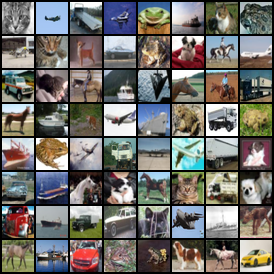

In [7]:
batch_size = 64
trainloader, _ = datasets.get_dataset(config,
                        uniform_dequantization=config.data.uniform_dequantization,
                        train_batch_size=batch_size)

original_images = next(iter(trainloader))[0].to(config.device)
#original_images = initial_sample.clone()
show_batch_imgs(original_images,8)

torch.Size([64, 3, 32, 32])


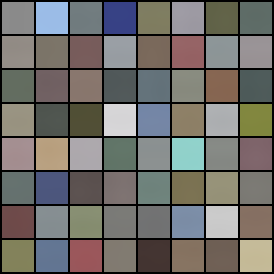

torch.Size([64, 3, 32, 32])

In [13]:
blur_type = 'fftblur'
scales = config.model.fftblur_schedule
forward_heat_module = mutils.create_forward_process_from_sigmas(
                                    config, scales, config.device,blur_type)

initial_sample = forward_heat_module(original_images,
                        config.model.K * torch.ones(original_images.shape[0], dtype=torch.long).to(config.device))

print(initial_sample.shape)
show_batch_imgs(initial_sample,8)
initial_sample[:,:] =

In [9]:
vector_imgs = torch.round(initial_sample.permute(1,0,2,3).reshape(3,-1),decimals=3)
print(vector_imgs.shape)
vector_imgs

torch.Size([3, 65536])


tensor([[0.5470, 0.5470, 0.5470,  ..., 0.7750, 0.7750, 0.7750],
        [0.5470, 0.5470, 0.5470,  ..., 0.7350, 0.7350, 0.7350],
        [0.5470, 0.5470, 0.5470,  ..., 0.6020, 0.6030, 0.6030]],
       dtype=torch.float64)

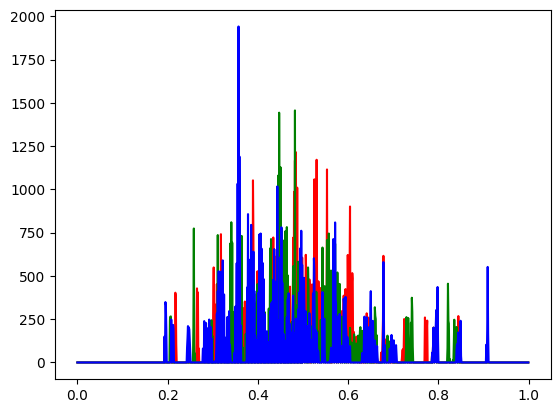

In [10]:
import matplotlib.pyplot as plt

bins = torch.round(torch.linspace(0, 1, 1001),decimals=3).to(torch.float64) #float
hist = [torch.histogram(c, bins=bins) for c in vector_imgs]

plt.plot(hist[0].bin_edges[:-1], hist[0].hist, color="r")
plt.plot(hist[1].bin_edges[:-1], hist[1].hist, color="g")
plt.plot(hist[2].bin_edges[:-1], hist[2].hist, color="b")


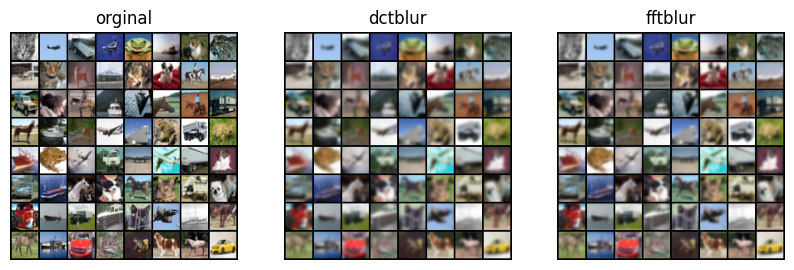

In [11]:
fig, axes = plt.subplots(1,3,figsize=(10,4))
#fig.dpi=300

blur_step = 60
nrow = 8
for col,blur_type in enumerate(['orginal','dctblur','fftblur']):
    if blur_type != 'orginal':
        if blur_type == 'dctblur' :
            scales = config.model.dctblur_schedule
        else:
            scales = config.model.fftblur_schedule

        heat_forward_module = mutils.create_forward_process_from_sigmas(config, scales, config.device,blur_type)

        initial_sample = heat_forward_module(original_images, #config.model.K *
                            blur_step * torch.ones(initial_sample.shape[0], dtype=torch.long).to(config.device))
    else:
        initial_sample = original_images.clone()
    img_grid = make_grid(initial_sample,nrow=nrow,padding=2)
    axes[col].imshow(img_grid.permute(1,2,0).cpu().detach().numpy())
    axes[col].set_title(f'{blur_type}')
    axes[col].axis('off')
plt.show()



In [12]:
n_step = 10
step_list = torch.round(torch.linspace(0,config.model.K,n_step)).long()  # [1,...,K]

fig, axes = plt.subplots(n_step,2,figsize=(10,4*n_step))
#fig.dpi=300
nrow = 8
initial_sample_dict = {'dctblur':[],'fftblur':[]}
for row,blur_step in enumerate(step_list):
    for col,blur_type in enumerate(['dctblur','fftblur']):

        if blur_type == 'dctblur' :
            scales = config.model.dctblur_schedule
        else:
            scales = config.model.fftblur_schedule

        heat_forward_module = mutils.create_forward_process_from_sigmas(config, scales, config.device,blur_type)

        initial_sample = heat_forward_module(original_images, #config.model.K *
                           blur_step * torch.ones(initial_sample.shape[0], dtype=torch.long).to(config.device))
        initial_sample_dict[blur_type].append(initial_sample)

        img_grid = make_grid(initial_sample,nrow=nrow,padding=2)
        axes[row,col].imshow(img_grid.permute(1,2,0).cpu().detach().numpy())
        axes[row,col].set_title(f'{blur_type}[{blur_step}]')
        axes[row,col].axis('off')
plt.show()


Output hidden; open in https://colab.research.google.com to view.

In [ ]:
img_org  = initial_sample_dict['fftblur'][0][42]
img_blur = initial_sample_dict['fftblur'][9][42]
img_org_mean =  torch.mean(initial_sample_dict['fftblur'][0][42].reshape(3,-1),1)[:,None,None]
img_blur_mean = torch.mean(initial_sample_dict['fftblur'][9][42].reshape(3,-1),1)[:,None,None]
print(f'img_org_mean = {img_org_mean.reshape(3)}  ,  \nimg_blur_mean = {img_blur_mean.reshape(3)}')
print('MSE(img_blur , img_org) = ',torch.mean((img_blur - img_org)**2).item())
print('MSE(img_blur , img_org_mean) = ',torch.mean((img_blur - img_org_mean)**2).item())


img_org_mean = tensor([0.6615, 0.6727, 0.6830], dtype=torch.float64)  ,  
img_blur_mean = tensor([0.6615, 0.6727, 0.6830], dtype=torch.float64)
MSE(img_blur , img_org) =  0.060455205811240864
MSE(img_blur , img_org_mean) =  1.8220002642205866e-06


In [ ]:
img_org  = initial_sample_dict['dctblur'][0][42]
img_blur = initial_sample_dict['dctblur'][9][42]
img_org_mean =  torch.mean(initial_sample_dict['dctblur'][0][42].reshape(3,-1),1)[:,None,None]
img_blur_mean = torch.mean(initial_sample_dict['dctblur'][9][42].reshape(3,-1),1)[:,None,None]
print(f'img_org_mean = {img_org_mean.reshape(3)}  ,  \nimg_blur_mean = {img_blur_mean.reshape(3)}')
print('MSE(img_blur , img_org) = ',torch.mean((img_blur - img_org)**2).item())
print('MSE(img_blur , img_org_mean) = ',torch.mean((img_blur - img_org_mean)**2).item())


img_org_mean = tensor([0.6615, 0.6727, 0.6830], dtype=torch.float64)  ,  
img_blur_mean = tensor([0.6615, 0.6727, 0.6830], dtype=torch.float64)
MSE(img_blur , img_org) =  0.05738201466337218
MSE(img_blur , img_org_mean) =  0.00011475142764703603


In [ ]:
(v1,m1)=torch.var_mean(initial_sample_dict['fftblur'][9][42].reshape(3,-1),dim=1)
print(v1,m1,torch.mean(v1))

tensor([2.0499e-06, 2.0665e-06, 1.3549e-06], dtype=torch.float64) tensor([0.6615, 0.6727, 0.6830], dtype=torch.float64) tensor(1.8238e-06, dtype=torch.float64)


In [ ]:
initial_sample_dict['dctblur'][9][42].reshape(3,-1).shape

torch.Size([3, 1024])

In [ ]:
torch.min(initial_sample_dict['dctblur'][9][42].reshape(3,-1),dim=1).values-torch.max(initial_sample_dict['dctblur'][9][42].reshape(3,-1),dim=1).values

tensor([-0.0407, -0.0412, -0.0326], dtype=torch.float64)

In [ ]:
torch.min(initial_sample_dict['fftblur'][9][42].reshape(3,-1),dim=1).values-torch.max(initial_sample_dict['fftblur'][9][42].reshape(3,-1),dim=1).values

tensor([-0.0053, -0.0052, -0.0042], dtype=torch.float64)

In [ ]:
sampel_var = {'dctblur':np.zeros((len(step_list),3)),'fftblur':np.zeros((len(step_list),3))}

In [ ]:
num_img = 42
sampel_var  = {'dctblur':[],'fftblur':[]}
sampel_diff = {'dctblur':[],'fftblur':[]}
for i in range(len(step_list)):
    for blur_type in ['dctblur','fftblur']:
        sample = initial_sample_dict[blur_type][i][num_img].reshape(3,-1)
        sampel_var[blur_type].append(torch.var(sample,dim=1))
        sampel_diff[blur_type].append(torch.max(sample,dim=1).values - torch.min(sample,dim=1).values)


In [ ]:
.shape

(3, 10)

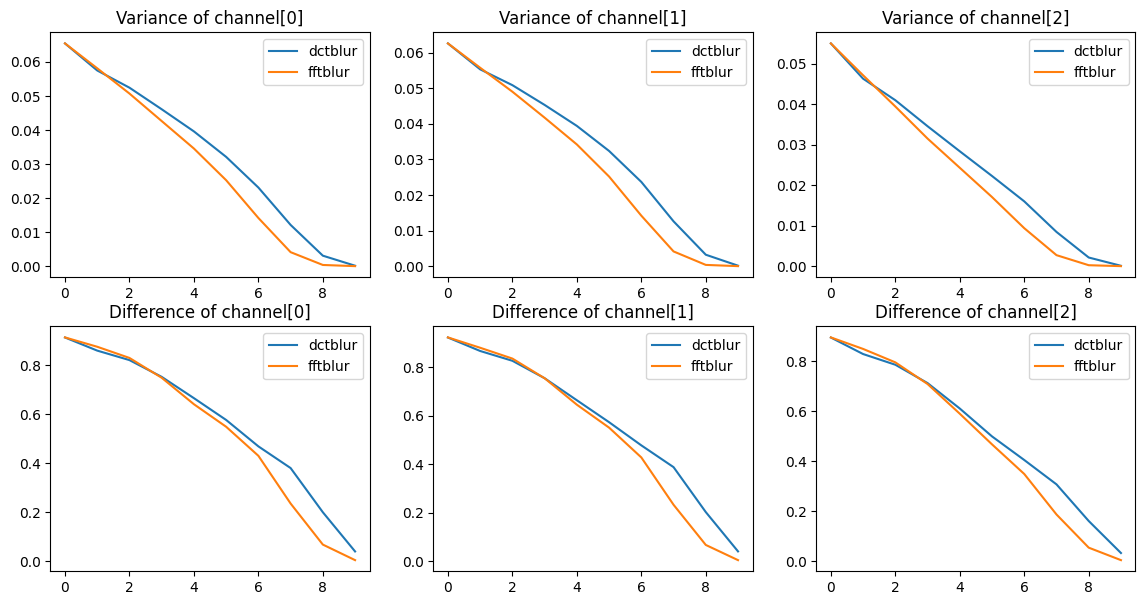

In [ ]:

num_img = 42
sampel_var  = {'dctblur':[],'fftblur':[]}
sampel_diff = {'dctblur':[],'fftblur':[]}
for i in range(len(step_list)):
    for blur_type in ['dctblur','fftblur']:
        sample = initial_sample_dict[blur_type][i][num_img].reshape(3,-1)
        sampel_var[blur_type].append(torch.var(sample,dim=1))
        sampel_diff[blur_type].append(torch.max(sample,dim=1).values - torch.min(sample,dim=1).values)

fig,axes = plt.subplots(2,3,figsize=(14,7))

for channel,_ in enumerate(['Red','Green','Blue']):
    for blur_type in ['dctblur','fftblur']:
        sampel_var_arr = np.array(sampel_var[blur_type]).transpose(1,0)
        axes[0,channel].plot(sampel_var_arr[channel],label=blur_type)
    axes[0,channel].set_title(f'Variance of channel[{channel}]')
    axes[0,channel].legend(loc="upper right")

    for blur_type in ['dctblur','fftblur']:
        sampel_diff_arr = np.array(sampel_diff[blur_type]).transpose(1,0)
        axes[1,channel].plot(sampel_diff_arr[channel],label=blur_type)
    axes[1,channel].set_title(f'Difference of channel[{channel}]')
    axes[1,channel].legend(loc="upper right")

plt.show()

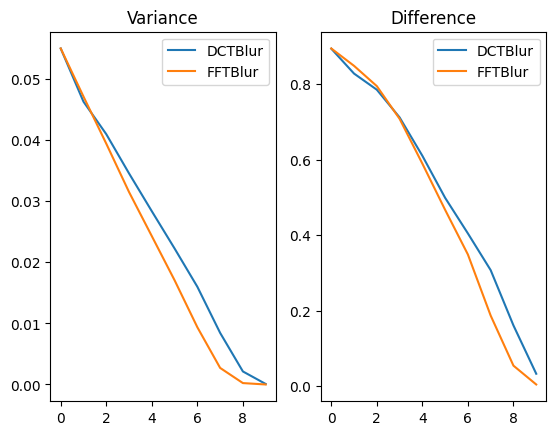

In [ ]:
vdct_list=[]
vfft_list=[]
diff_dct_list =[]
diff_fft_list = []
channel = 2
for i in range(10):
    dct_sample = initial_sample_dict['dctblur'][i][42].reshape(3,-1)
    fft_sample = initial_sample_dict['fftblur'][i][42].reshape(3,-1)
    vdct=torch.var(dct_sample,dim=1)
    vfft=torch.var(fft_sample,dim=1)
    vdct_list.append(vdct[channel])#torch.mean(vdct))
    vfft_list.append(vfft[channel])#torch.mean(vfft))
    dct_diff = torch.max(dct_sample,dim=1).values - torch.min(dct_sample,dim=1).values
    diff_dct_list.append(dct_diff[channel])
    fft_diff = torch.max(fft_sample,dim=1).values - torch.min(fft_sample,dim=1).values
    diff_fft_list.append(fft_diff[channel])

fig,axes = plt.subplots(1,2)#,figsize=(14,7))
axes[0].plot(vdct_list,label='DCTBlur')
axes[0].plot(vfft_list,label='FFTBlur')
axes[0].legend(loc="upper right")
axes[0].set_title(f'Variance')

axes[1].plot(diff_dct_list,label='DCTBlur')
axes[1].plot(diff_fft_list,label='FFTBlur')
axes[1].legend(loc="upper right")
axes[1].set_title(f'Difference')

plt.show()

In [ ]:
import matplotlib.pyplot as plt

bins = torch.round(torch.linspace(0, 1, 1001),decimals=3).to(torch.float64) #float
hist = [torch.histogram(c, bins=bins) for c in vector_imgs]

plt.plot(hist[0].bin_edges[:-1], hist[0].hist, color="r")
plt.plot(hist[1].bin_edges[:-1], hist[1].hist, color="g")
plt.plot(hist[2].bin_edges[:-1], hist[2].hist, color="b")

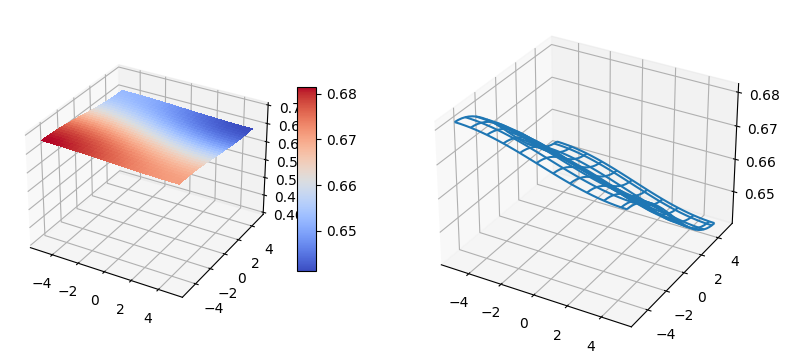

In [ ]:
img = initial_sample_dict['dctblur'][9][42].permute(1,2,0)[:,:,0]

import matplotlib.pyplot as plt
import numpy as np

from matplotlib import cm

# set up a figure twice as wide as it is tall
fig = plt.figure(figsize=plt.figaspect(0.5))

# =============
# First subplot
# =============
# set up the axes for the first plot
ax = fig.add_subplot(1, 2, 1, projection='3d')

# plot a 3D surface like in the example mplot3d/surface3d_demo
X = np.linspace(-5, 5, 32)
Y = np.linspace(-5, 5, 32)
X, Y = np.meshgrid(X, Y)

Z = img
surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
ax.set_zlim(0.4, 0.7)
fig.colorbar(surf, shrink=0.5, aspect=10)

# ==============
# Second subplot
# ==============
# set up the axes for the second plot
ax = fig.add_subplot(1, 2, 2, projection='3d')

# plot a 3D wireframe like in the example mplot3d/wire3d_demo
#X, Y, Z = get_test_data(0.05)
ax.plot_wireframe(X, Y, Z, rstride=3, cstride=3)

plt.show()

In [ ]:
def show_img_3d(img):
    ax = plt.figure().add_subplot(projection='3d')
    X = np.linspace(0, 31, 32)
    Y = np.linspace(0, 31, 32)
    X, Y = np.meshgrid(X, Y)

    Z = img

    # Plot the 3D surface
    ax.plot_surface(X, Y, Z, edgecolor='royalblue', lw=0.5, rstride=8, cstride=8,
                    alpha=0.3)

    # Plot projections of the contours for each dimension.  By choosing offsets
    # that match the appropriate axes limits, the projected contours will sit on
    # the 'walls' of the graph
    ax.contourf(X, Y, Z, zdir='z',offset=-1, cmap='coolwarm') #
    ax.contourf(X, Y, Z, zdir='x',offset=-10,  cmap='coolwarm') #
    ax.contourf(X, Y, Z, zdir='y',offset=40,  cmap='coolwarm') #

    ax.set(xlim=(-10, 40), ylim=(-10, 40), zlim=(-1, 1),
        xlabel='X', ylabel='Y', zlabel='Z')

    plt.show()

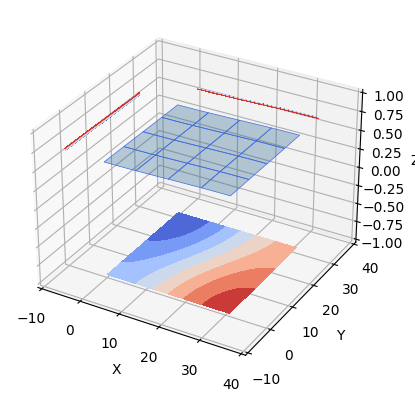

In [ ]:
img = initial_sample_dict['dctblur'][9][42].permute(1,2,0)[:,:,0]
show_img_3d(img)


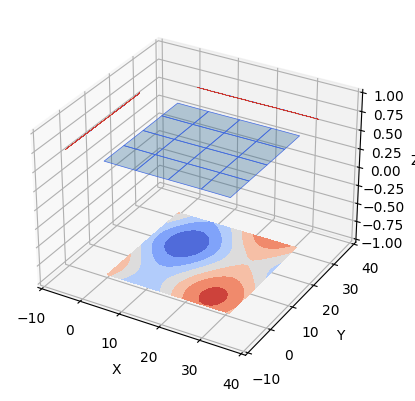

In [ ]:
img = initial_sample_dict['fftblur'][9][42].permute(1,2,0)[:,:,0]
show_img_3d(img)


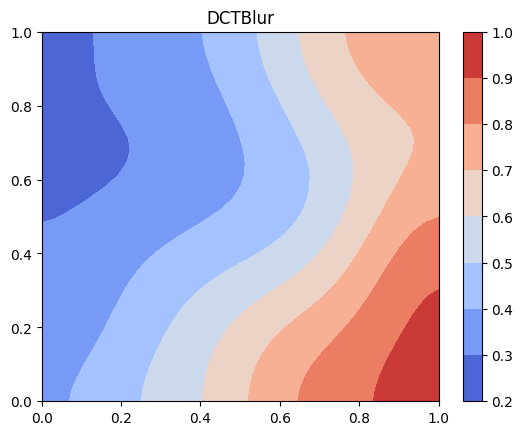

In [ ]:
img = initial_sample_dict['dctblur'][5][42].permute(1,2,0)[:,:,0]

import matplotlib.pyplot as plt
import numpy as np

# Generate data for the plot
x = np.linspace(0, 1, 32)
y = np.linspace(0, 1, 32)
r = np.random.RandomState(42)
z = img
# Generate the plot
fig, ax = plt.subplots()
cmap = plt.contourf(x, y, z,cmap='coolwarm')
fig.colorbar(cmap)
plt.title('DCTBlur')
plt.show(fig)

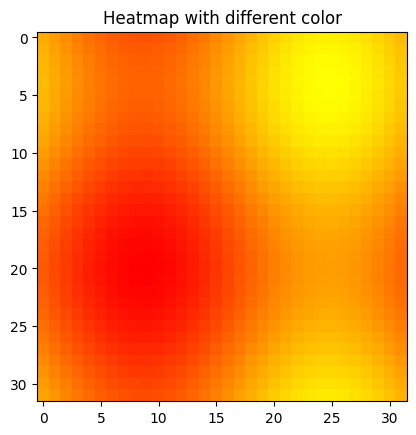

In [ ]:

# Program to plot 2-D Heat map
# using matplotlib.pyplot.imshow() method
import numpy as np
import matplotlib.pyplot as plt

data = img
plt.imshow(data, cmap='autumn', interpolation='nearest')

plt.title("Heatmap with different color")
plt.show()

In [ ]:
workdir = './runs/cifar/dctblur'
checkpoint_meta_dir = os.path.join(workdir, "checkpoints-meta", "checkpoint.pth")

model = mutils.create_model(config)
loaded_state = torch.load(checkpoint_meta_dir, map_location=config.device)
model.load_state_dict(loaded_state['model'], strict=False)
initial_step = int(loaded_state['step'])
print('initial_step:',initial_step)
model_evaluation_fn = mutils.get_model_fn(model, train=False)

#print('initial_sample.shape',initial_sample.shape)
#print('initial_sample[0,0]',initial_sample[0,0])
#initial_sample = torch.zeros((128,3,32,32))
#initial_sample =initial_sample + torch.rand((128,3))[:,:,None,None]
sampling_fn = sampling.get_sampling_fn_inverse_heat(config,
                                                            initial_sample, intermediate_sample_indices=list(
                                                                range(config.model.K+1)),
                                                            delta=config.model.sigma*1.25, device=config.device)

sample, n, intermediate_samples = sampling_fn(model_evaluation_fn)